# CTD Cast vs Mount Temperature Data at Folger Pinnacle (11/07/2023)

- scroll all the way down to see my notes and plots

In [962]:
# set up environment ?
import pandas as pd
import onc
import os
import json
from typing import List, Tuple
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from functools import reduce

#token = os.environ["TRICY_TOKEN"]

from dotenv import load_dotenv
load_dotenv()
token = os.getenv("ONC_TOKEN")

# Create ONC client
my_onc = onc.ONC(token)

In [963]:
def get_property(start: str, end: str, locationCode: str, deviceCategoryCode: str, sensorCategoryCode: str) -> pd.DataFrame:
    """
    Fetches scalar data using the ONC Python SDK for a given location, device category, sensor property,
    and time window. Returns a merged DataFrame with timestamps and sensor values.

    Parameters:
        start (str): Start date in ISO 8601 format (e.g., "2023-07-11T17:00:00.000Z").
        end (str): End date in ISO 8601 format (e.g., "2023-07-11T22:30:00.000Z").
        locationCode (str): ONC location code (e.g., "CF341").
        deviceCategoryCode (str): ONC device category (e.g., "CTD").
        sensorCategoryCode (str): Comma-separated sensor types to fetch (e.g., "depth,temperature").

    Returns:
        pd.DataFrame: DataFrame containing merged sensor values with a timestamp index.
                    schema: timestamp: datetime obj, {prop}: int, uom: str
    """
    params = {
        "locationCode": locationCode,
        "deviceCategoryCode": deviceCategoryCode,
        "sensorCategoryCodes": sensorCategoryCode,
        "dateFrom": start,
        "dateTo" : end
    }

    # JSON response from ONC
    result = my_onc.getScalardata(params)

    # error handle if there is no data returned
    if not result or "sensorData" not in result or result["sensorData"] is None or len(result["sensorData"]) == 0:
        print(f"No data returned for devices in {deviceCategoryCode} at {locationCode} between {start} and {end}.")
        return
        
    else:
        # extract the relevant sensors from the JSON response

        dfs = []

        for sensor in result["sensorData"]:
            # extract each sensors data fields
            prop = sensor["sensorCategoryCode"]
            times = sensor["data"]["sampleTimes"]
            values = sensor["data"]["values"]
            unit = sensor["unitOfMeasure"]

            # populate dataframe (Pandas)
            # schema: timestamp: datetime obj, {prop}: int, uom: str
            df = pd.DataFrame({
                # syntax: "label": variable
                "timestamp": pd.to_datetime(times), # convert strings to datetime objects
                prop: values,
                "uom": unit
            })
            dfs.append(df)

    # merge dataframes by joining on timestamp    
    df_merged = reduce(lambda left, right: pd.merge(left, right, on="timestamp", how="outer"), dfs)
    df_merged.sort_values("timestamp", inplace=True)
    
    #df_merged.head()
    return df_merged

In [ ]:
def detect_cast_intervals(df: pd.DataFrame, gap_threshold_minutes: int = 10) -> List[Tuple[pd.Timestamp, pd.Timestamp]]:
    """
    Detects individual CTD cast intervals based on time gaps in the data.

    Parameters:
        df (pd.DataFrame): DataFrame with a 'timestamp' column (datetime format).
        gap_threshold_minutes (int): Time gap threshold to detect breaks between casts.

    Returns:
        List[Tuple[pd.Timestamp, pd.Timestamp]]: List of (dateFrom, dateTo) pairs in ISO 8601 UTC format.
    """
    if df.empty or "timestamp" not in df.columns:
            return []

    # sort df by timestamp
    df = df.sort_values("timestamp").reset_index(drop=True)

    gaps = df["timestamp"].diff().fillna(pd.Timedelta(seconds=0)) # calculate difference between each time stamp and store in gaps: pandas.Series
    new_cast_starts = df.index[gaps > pd.Timedelta(minutes=gap_threshold_minutes)].tolist() # if gap > 10 mins then it's index is added to new_cast_starts list

    cast_starts = [0] + new_cast_starts
    cast_ends = new_cast_starts + [len(df)] # list of end timestamps

    # Format as ISO 8601 string with milliseconds and 'Z' for UTC
    intervals = [
        (
            df["timestamp"].iloc[start_idx],
            df["timestamp"].iloc[end_idx - 1]
        )
        for start_idx, end_idx in zip(cast_starts, cast_ends)
    ]

    return intervals

In [965]:
def detect_deep_intervals(df: pd.DataFrame, depth_threshold: int, gap_threshold_seconds: int = 60) -> List[Tuple[pd.Timestamp, pd.Timestamp]]: #TODO: change from str returns to timestamp
    """
    Detects continuous time intervals where depth exceeds a threshold.
    
    Parameters:
        df (pd.DataFrame): DataFrame with 'timestamp' and 'depth' columns.
        depth_threshold (float): Minimum depth to include.
        gap_threshold_seconds (int): Max allowed time gap between points within an interval.
    
    Returns:
        List[Tuple[str, str]]: List of (start, end) timestamp strings in ISO 8601 UTC format.
    """

    # Filter for rows deeper than the threshold
    df_deep = df[df["depth"] > depth_threshold].copy()

    if df_deep.empty:
        return []

    # Sort by time and calculate time gaps
    df_deep = df_deep.sort_values("timestamp").reset_index(drop=True)
    df_deep["delta"] = df_deep["timestamp"].diff().dt.total_seconds().fillna(0)

    intervals = []
    start_time = df_deep.loc[0, "timestamp"]

    for i in range(1, len(df_deep)):
        if df_deep.loc[i, "delta"] > gap_threshold_seconds:
            end_time = df_deep.loc[i - 1, "timestamp"]
            intervals.append((start_time, end_time))
            start_time = df_deep.loc[i, "timestamp"]

    # Add the final interval
    intervals.append((start_time, df_deep.iloc[-1]["timestamp"]))

    return intervals

In [966]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

def plot_cast(start: pd.Timestamp, end: pd.Timestamp, locationCode: str, deviceCategoryCode: str,
              sensorCategoryCode: str, df: pd.DataFrame, depth_theshold: int) -> None:
    """
    Plots a CTD cast with time as the bottom x-axis and temperature as the top x-axis.

    Parameters:
        start (pd.Timestamp): Start time.
        end (pd.Timestamp): End time.
        locationCode (str): ONC location code.
        deviceCategoryCode (str): ONC device category.
        sensorCategoryCode (str): Sensor property (e.g., "depth").
        df (pd.DataFrame): DataFrame with 'timestamp', 'temperature', and 'depth'.
        depth_theshold (int): Minimum depth to include.

    Returns:
        None
    """
    
    # Filter by time and depth
    df_int = df[
        (df["timestamp"] >= start) &
        (df["timestamp"] <= end) &
        (df["depth"] >= depth_theshold)
    ]

    if df_int.empty:
        print(f"Skipping empty cast interval: {start} to {end}")
        return

    df_int = df_int.sort_values("timestamp")

    fig, ax = plt.subplots(figsize=(10, 6))

    # Main plot: Time vs Depth (on bottom x-axis)
    ax.plot(df_int["timestamp"], df_int["depth"], color="tab:blue", label="CTD Cast")
    ax.set_xlabel("Time (UTC)")
    ax.set_ylabel("Depth (m)")
    ax.invert_yaxis()

    # Format time ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

    # Title
    title_str = (
        f"CTD Cast at {locationCode}:\n"
        f"{start.strftime('%H:%M:%S.%f')[:-4]} to {end.strftime('%H:%M:%S.%f')[:-4]} "
        f"{end.strftime('%B %d, %Y')}"
    )
    ax.set_title(title_str, fontweight="bold")

    # Add top x-axis: Temperature
    ax2 = ax.twiny()

    # Align top axis scale with bottom axis
    ax2.set_xlim(ax.get_xlim())

    # Choose evenly spaced time ticks on x-axis
    temp_ticks = np.linspace(df_int["timestamp"].min().value, df_int["timestamp"].max().value, 5)
    temp_ticks = pd.to_datetime(temp_ticks)

    # Interpolate corresponding temperature values for those time ticks
    interp_temp = np.interp(
        mdates.date2num(temp_ticks),
        mdates.date2num(df_int["timestamp"]),
        df_int["temperature"]
    )

    ax2.set_xticks(mdates.date2num(temp_ticks))
    ax2.set_xticklabels([f"{t:.1f}°C" for t in interp_temp])
    ax2.set_xlabel("Temperature (°C)")

    plt.tight_layout()
    plt.show()


In [967]:
def plot_mount(start: pd.Timestamp, end: pd.Timestamp, locationCode: str, deviceCategoryCode: str,
                  sensorCategoryCode: str, df: pd.DataFrame) -> None:
    """
    Plots a sensor property time-series with optional cast interval markers.

    Parameters:
        start (pd.Timestamp): Start time in ISO 8601 format.
        end (pd.Timestamp): End time in ISO 8601 format.
        locationCode (str): ONC location code.
        deviceCategoryCode (str): ONC device category.
        sensorCategoryCode (str): Sensor property (e.g., "depth").
        df (pd.DataFrame): DataFrame containing 'timestamp' and property column.
    
    Returns:
        None
    """
    df_int = df[(df["timestamp"] >= start) & (df["timestamp"] <= end)] # filter the df to get the relevant cast interval

    ax = fig, ax = plt.subplots(figsize=(11.5, 6))
    ax.set_xlabel("Time (UTC)")
    ax.set_ylabel("Temperature (°C)")
    ax.plot(df_int["timestamp"], df_int["temperature"], label="Mount")
    ax.set_xlim([start - pd.Timedelta(seconds=1), end + pd.Timedelta(seconds=1)])  # Set same x-limits

    title_str = f"CTD Mount at {locationCode}:\n{start.strftime('%H:%M:%S.%f')[:-4]} to {end.strftime('%H:%M:%S.%f')[:-4]} {end.strftime('%B %d, %Y')}"
    plt.title(title_str, fontweight = "bold")

In [968]:
def combined_plot(start: pd.Timestamp, end: pd.Timestamp, cast_df: pd.DataFrame, mount_df: pd.DataFrame, cast_locationCode: str, mount_locationCode: str) -> None:
    """
    Plots mount temperature vs. time and cast depth vs. time (colored by temperature),
    aligned on the same time axis for visual comparison.

    Parameters:
        start (pd.Timestamp): Start time in ISO 8601 format.
        end (pd.Timestamp): End time in ISO 8601 format.
        cast_df (pd.DataFrame): DataFrame containing 'timestamp', 'temperature', and 'depth'.
        mount_df (pd.DataFrame): DataFrame containing 'timestamp' and 'temperature'.
        cast_locationCode (str): Label for the cast sensor.
        mount_locationCode (str): Label for the mount sensor.
    
    Returns:
        None
    """

    # Slice to interval
    cast_slice = cast_df[(cast_df["timestamp"] >= start) & (cast_df["timestamp"] <= end)]
    mount_slice = mount_df[(mount_df["timestamp"] >= start) & (mount_df["timestamp"] <= end)]

    # Start plot
    fig, ax1 = plt.subplots(figsize=(10, 6))
 
    # Label axes
    ax1.set_xlabel("Time (UTC)")
    ax1.set_ylabel("Temperature (°C)")
    
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

    ax1.plot(cast_slice["timestamp"], cast_slice["temperature"], color="tab:blue", label="Cast") # Plot cast (blue)
    ax1.plot(mount_slice["timestamp"], mount_slice["temperature"], color="tab:orange", label="Mount") # Plot mount (orange)
    ax1.set_xlim([start - pd.Timedelta(seconds=1), end + pd.Timedelta(seconds=1)])  # Set same x-limits
    
    # Add depth as top x-axis, aligned to cast time
    ax2 = ax1.twiny()

    # Depth ticks — 5 evenly spaced depth values
    depth_ticks = np.linspace(cast_slice["depth"].min(), cast_slice["depth"].max(), num=5)

    # Interpolate corresponding time positions for those depths
    time_numeric = mdates.date2num(cast_slice["timestamp"])
    depth_numeric = cast_slice["depth"].to_numpy()
    tick_locs = np.interp(depth_ticks, depth_numeric, time_numeric)

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(tick_locs)
    ax2.set_xticklabels([f"{int(d)} m" for d in depth_ticks])
    ax2.set_xlabel("Depth (m)")

    # Title
    title_str = f"{start.strftime('%H:%M:%S.%f')[:-4]} to {end.strftime('%H:%M:%S.%f')[:-4]} {end.strftime('%B %d, %Y')}"
    plt.title(f"Overlay of Cast and Mount at Folger Pinnacle\n{title_str}", fontweight="bold")

    ax1.legend(loc="best")

    plt.tight_layout()
    plt.show()

### CTD Cast vs Mount Temperature Data at Fogler Pinnacle

Notes:
 - I estimated Pinnacle depth as 23m and have filtered cast data for when the cast is at least 20m deep
- Other than displaying data from the exact time frame of the cast, and filtering for the sub section where the cast is at least 20m deep, I have applied to no real processing
- I have not yet put the mount and cast data on the same plot, but that will be a goal for tomorrow

Possible Issues:
- Closeness of depth needed to compare casts/mounts and extremely small time series 
- Couldn't find casts more recent than 2023 at Fogler Deep & Passage -> did you guy not cast there last year?

### Date of Interest: July 11, 2023

In [969]:
# date of interest: July 11, 2023
# note: I narrowed down the time slot using the plotting utility on Oceans 3.0
dateFrom = "2023-07-11T17:00:00.000Z"
dateTo = "2023-07-11T22:30:00.000Z"

# fetch data for CTD casts and mounts from July 11, 2023
cast_df = get_property(dateFrom, dateTo, "CF341", "CTD", "depth,temperature") # populate dataframe of entire day
mount_df = get_property(dateFrom, dateTo, "FGPPN", "CTD", "temperature")


### Detect cast time intervals and isolate respective cast and mount data

In [970]:
# isolate cast time intervals, and deep section of each cast
cast_ints = detect_cast_intervals(cast_df, 10) # isolate time intervals for each cast
deep_ints = detect_deep_intervals(cast_df, 20, 60) # isolate time intervals for deep section (>= 20m)of each cast

# isolate cast 1 and 2 deep sections
cast_start1,cast_end1 = deep_ints[0]
cast_start2,cast_end2 = deep_ints[1]

# print intervals to console
print("Cast intervals (UTC):")
for cast_start, cast_end in cast_ints:
   print(f"Start: {cast_start}, End: {cast_end}")

print()

print("Deep section of cast intervals (UTC):")
for cast_start, cast_end in deep_ints:
   print(f"Start: {cast_start}, End: {cast_end}")

Cast intervals (UTC):
Start: 2023-07-11T17:12:51.000Z, End: 2023-07-11T17:14:20.000Z
Start: 2023-07-11T20:13:27.000Z, End: 2023-07-11T20:15:39.000Z

Deep section of cast intervals (UTC):
Start: 2023-07-11 17:13:58.780000+00:00, End: 2023-07-11 17:14:20.890000+00:00
Start: 2023-07-11 20:15:03.130000+00:00, End: 2023-07-11 20:15:39.880000+00:00


### Combined plot

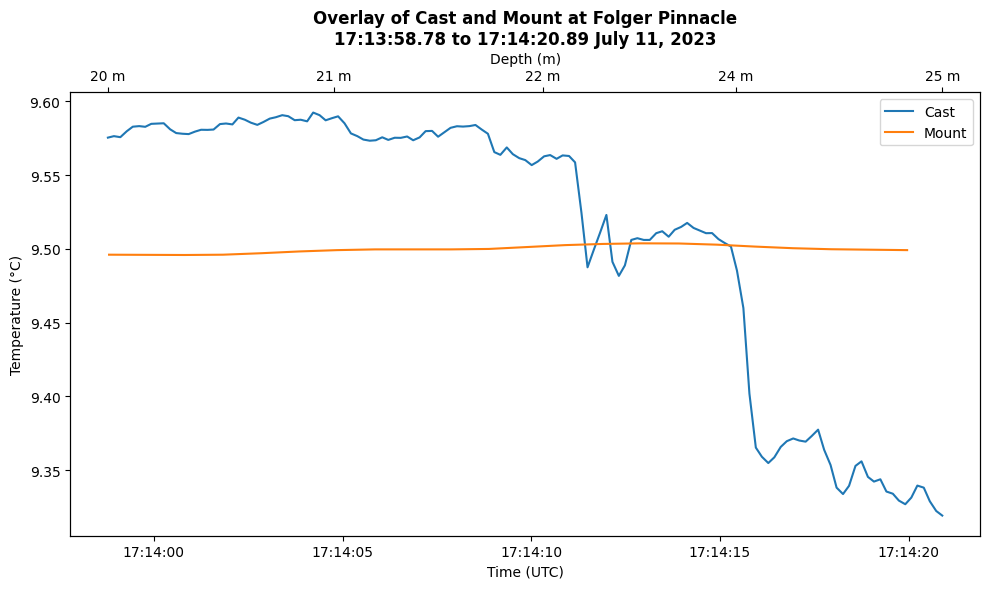

In [971]:
combined_plot(cast_start1, cast_end1, cast_df, mount_df, "FGPPN", "CTD")

### Plot cast 1 and mount temperature data

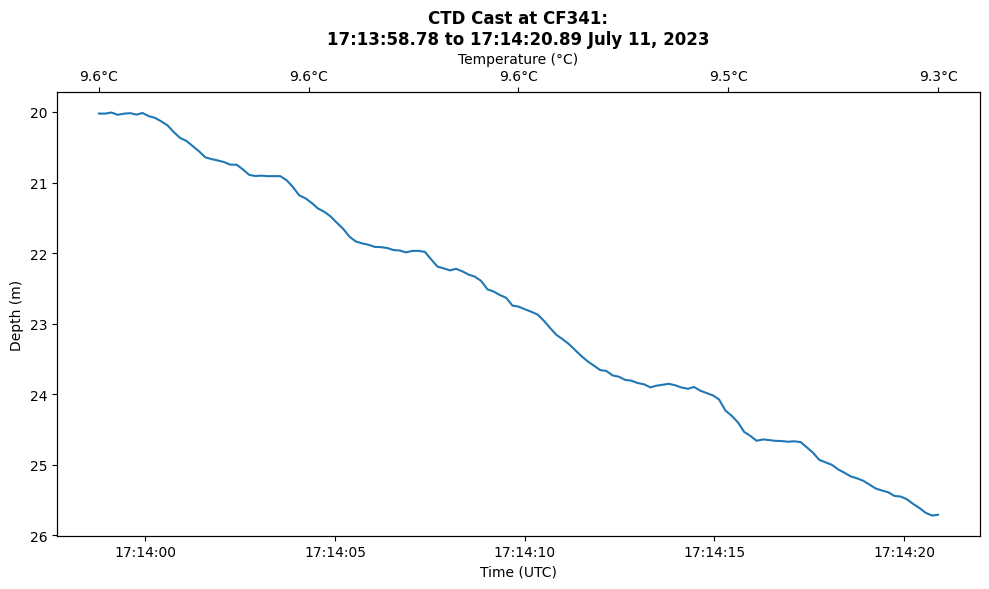

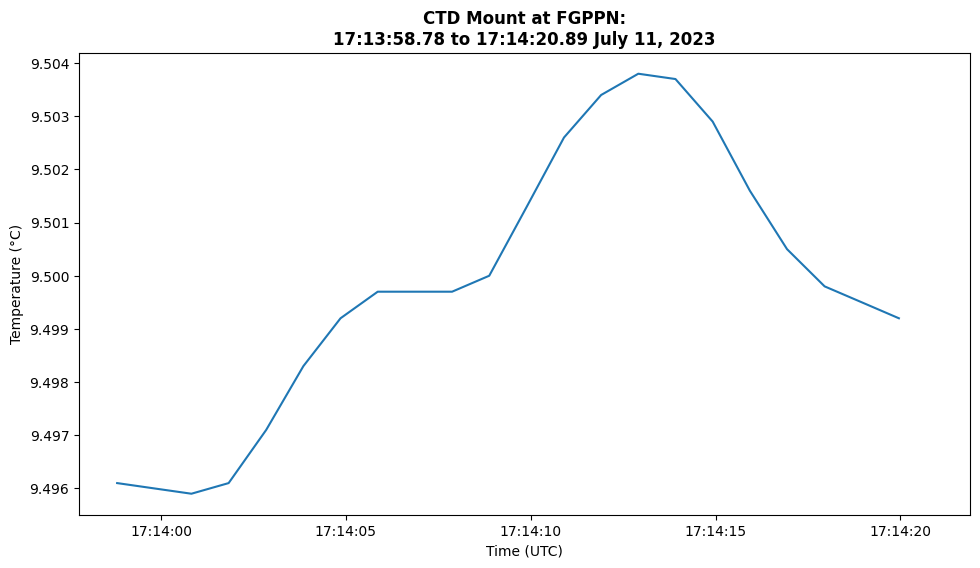

In [972]:
#Plot cast 1 and mount temperature data
plot_cast(cast_start1, cast_end1, "CF341", "CTD", "depth", cast_df, 20) # plot depth and temperature profile for each cast
plot_mount(cast_start1, cast_end1, "FGPPN", "CTD", "depth", mount_df) # plot temperature and time profile for each mount

### Plot cast 2 and mount temperature data

In [973]:
# Plot cast 2 and mount temperature data
# plot_cast(cast_start2, cast_end2, "CF341", "CTD", "depth", cast_df, 20) # plot depth and temperature profile for each cast
# plot_mount(cast_start2, cast_end2, "FGPPN", "CTD", "depth", mount_df) # plot temperature and time profile for each mount

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1cd2cd01-70e8-41b6-af2d-f797c6675dbe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>